In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

2022-11-10 18:01:42.316446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

data:
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download

In [2]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

print(movie_reviews.isnull().values.any())

movie_reviews.shape

False


(50000, 2)

In [3]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [5]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
X=movie_reviews['review'].apply(lambda review: preprocess_text(review)).values

In [8]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [9]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [11]:
unique,counts= np.unique(y,return_counts=True)
print(unique)
counts

[0 1]


array([25000, 25000])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


Text(0.5, 1.0, 'Words Number Distribution')

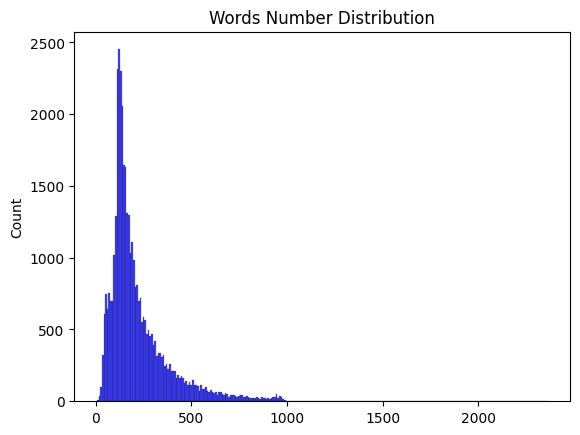

In [13]:
# how long are reviews
sns.histplot(data=[len(x.split(" ")) for x in X_train], color='blue').set_title('Words Number Distribution')


In [14]:
# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(X_train)

# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
# vocab_size = len(tokenizer.word_index) + 1

# maxlen = 256

# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-11-10 18:14:59.233449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:1])
  print()
  print('labels: ', label.numpy()[:1])

texts:  [b'I was looking for ATTACK on Precinct There the film is THAT memorable Who is the star of this Ethan Hawke or Matt Dillon can tell who the lead actor is that a pretty big point against the movie right there Gabriel Byrne who could have needed the money this badly could he Drea De Matteo is stunning but only because of her amazing body It took me ages to finally work out she Joey sister off Friends agree that the so called SWAT people attacking the station are pretty crap as far as tactics go We were even taught better basic skills than this in RAF basic training Avoid this even the snow doesn want to fall on bus full of prisoners Very bad continuity indeed Avoid like the plague ']

labels:  [0]


2022-11-10 18:15:00.987829: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [16]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,output_sequence_length=500)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [17]:
vocab = encoder.get_vocabulary()
np.array(vocab[:20])

array(['', '[UNK]', 'the', 'and', 'of', 'to', 'is', 'it', 'in', 'this',
       'that', 'was', 'as', 'movie', 'for', 'with', 'but', 'film', 'you',
       'on'], dtype='<U5')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [20]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 125,   11,  252, ...,    0,    0,    0],
       [  22,    1,    1, ...,    7,    6, 4851],
       [ 125,  166,    7, ...,    0,    0,    0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [21]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(np.array(vocab)[encoded_example[n]]))
  print()

Original:  b'I was looking for ATTACK on Precinct There the film is THAT memorable Who is the star of this Ethan Hawke or Matt Dillon can tell who the lead actor is that a pretty big point against the movie right there Gabriel Byrne who could have needed the money this badly could he Drea De Matteo is stunning but only because of her amazing body It took me ages to finally work out she Joey sister off Friends agree that the so called SWAT people attacking the station are pretty crap as far as tactics go We were even taught better basic skills than this in RAF basic training Avoid this even the snow doesn want to fall on bus full of prisoners Very bad continuity indeed Avoid like the plague '
Round-trip:  i was looking for attack on [UNK] there the film is that memorable who is the star of this ethan hawke or matt dillon can tell who the lead actor is that a pretty big point against the movie right there gabriel byrne who could have needed the money this badly could he [UNK] de [UNK] is

In [22]:
word_index = dict(zip(vocab, range(len(vocab))))
print(len(vocab))

10000


In [23]:
test = ["the", "cat", "sat", "on", "the","mike","max","reasons"]
[word_index[w] for w in test]

[2, 1094, 1761, 19, 2, 1685, 1928, 965]

In [24]:
path_to_glove_file = "glove.6B/glove.6B.200d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [25]:
num_tokens = len(vocab) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        if misses<10:
            print(word)
print("Converted %d words (%d misses)" % (hits, misses))


[UNK]
hadn
imho
Converted 9996 words (4 misses)


## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(num_tokens, embedding_dim,   #, mask_zero=True
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 200)          2000400   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 256)         336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                        

In [44]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,verbose=1)

Epoch 1/10
313/313 [==============================] - 678s 2s/step - loss: 0.6102 - accuracy: 0.6647 - val_loss: 0.4927 - val_accuracy: 0.7766
Epoch 2/10


2022-11-10 15:24:32.720639: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 661s 2s/step - loss: 0.4944 - accuracy: 0.7767 - val_loss: 0.4680 - val_accuracy: 0.7917
Epoch 3/10


2022-11-10 15:35:33.320794: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 660s 2s/step - loss: 0.4506 - accuracy: 0.8038 - val_loss: 0.4244 - val_accuracy: 0.8154
Epoch 4/10


2022-11-10 15:46:33.718664: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 666s 2s/step - loss: 0.4476 - accuracy: 0.8009 - val_loss: 0.5031 - val_accuracy: 0.7750
Epoch 5/10


2022-11-10 15:57:39.608484: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 677s 2s/step - loss: 0.4309 - accuracy: 0.8130 - val_loss: 0.4568 - val_accuracy: 0.7747
Epoch 6/10


2022-11-10 16:08:56.407164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 663s 2s/step - loss: 0.4125 - accuracy: 0.8219 - val_loss: 0.4042 - val_accuracy: 0.8242
Epoch 7/10


2022-11-10 16:19:59.175424: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 662s 2s/step - loss: 0.3988 - accuracy: 0.8290 - val_loss: 0.4277 - val_accuracy: 0.8143
Epoch 8/10


2022-11-10 16:31:01.056473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 705s 2s/step - loss: 0.3855 - accuracy: 0.8359 - val_loss: 0.3916 - val_accuracy: 0.8266
Epoch 9/10


2022-11-10 16:42:45.819928: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 693s 2s/step - loss: 0.3700 - accuracy: 0.8425 - val_loss: 0.3762 - val_accuracy: 0.8430
Epoch 10/10


2022-11-10 16:54:18.608467: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


313/313 [==============================] - 667s 2s/step - loss: 0.3860 - accuracy: 0.8369 - val_loss: 0.4030 - val_accuracy: 0.8229


2022-11-10 17:05:25.528341: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [45]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


In [29]:
new_model = tf.keras.models.load_model('sentiment_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 500, 200)          2000400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 500, 256)         336896    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                      

In [32]:
score = new_model.evaluate(test_dataset, verbose=1)


79/79 [==============================] - 78s 975ms/step - loss: 0.3962 - accuracy: 0.8271


In [41]:


sample_text = ('The movie was not bad')             
predictions = new_model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 69ms/step
[[0.15745758]]


In [ ]:
print('hi')

In [42]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

NameError: name 'history' is not defined

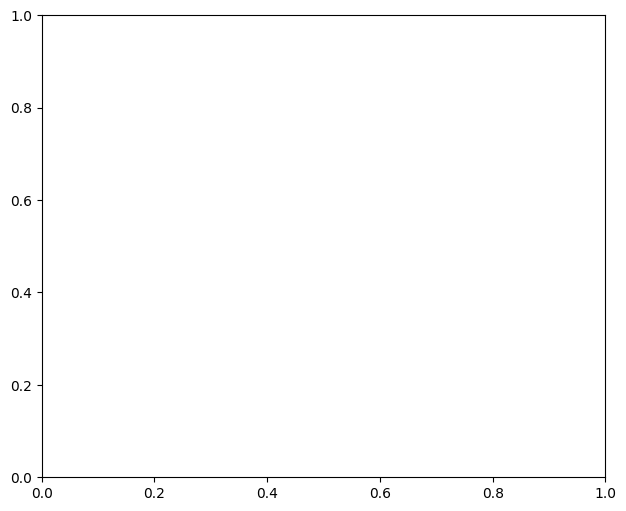

In [43]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
